# Первая часть проекта. Эксперименты

## 3. Подбор $\mathcal{A}$ при фиксированных параметрах распределений.

### 3.1. Для конкретного n, с иллюстрациями

In [81]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from dataclasses import dataclass
from tqdm import tqdm
from itertools import product

from graphs import KNN_Graph, Distance_Graph
from characteristics import *
from visualisations import *

import sys

In [82]:
n_param = 100
lambda_param = 2 / np.sqrt(3)
alpha_param = 3

In [117]:
k = 15
d = 0.005

In [118]:
exp_points = []
pareto_points = []

for _ in tqdm(range(500)):
    numbers_exp = np.random.exponential(1/lambda_param, n_param)
    numbers_pareto = (np.random.pareto(alpha_param, n_param) + 1)

    # в свете результатов первых двух экспериментов используем характеристики ДИСТАНЦИОННОГО графа
    distance_graph_exp = Distance_Graph(n=n_param, d_distance=d)
    distance_graph_pareto = Distance_Graph(n=n_param, d_distance=d)
    distance_graph_exp.build_from_numbers(numbers_exp)
    distance_graph_pareto.build_from_numbers(numbers_pareto)

    chars = create_characteristics(None, distance_graph_exp, None, distance_graph_pareto, "dist")

    exp_points.append((chars.distance_exp_components, chars.distance_pareto_chromatic))
    pareto_points.append((chars.distance_pareto_components, chars.distance_pareto_chromatic))

100%|██████████| 500/500 [00:02<00:00, 181.71it/s]


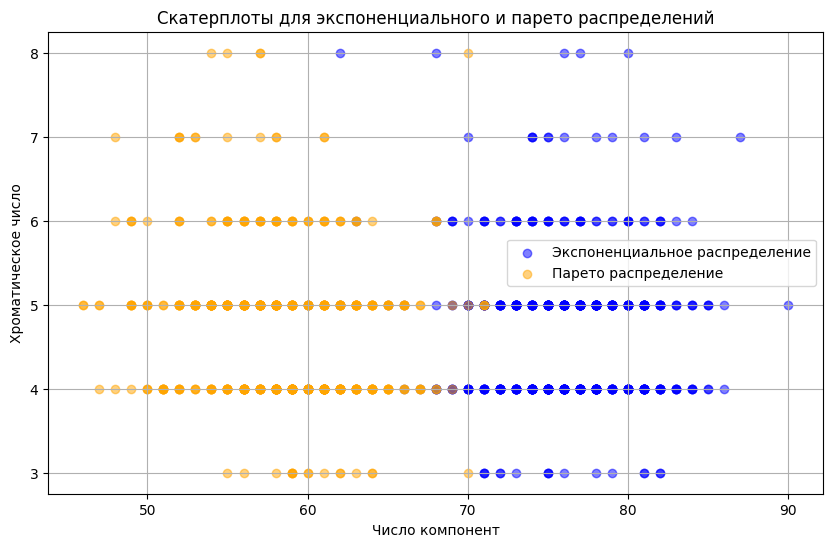

In [85]:
draw_two_points_sets(exp_points, pareto_points, title='Скатерплоты для экспоненциального и парето распределений',
                     xlabel='Число компонент', ylabel='Хроматическое число',
                     first_legend='Экспоненциальное распределение', second_legend='Парето распределение')

In [119]:
exp_points = np.array(exp_points)
pareto_points = np.array(pareto_points)

unique_exp_points = np.unique(exp_points, axis=0)
unique_pareto_points = np.unique(pareto_points, axis=0)

In [102]:
A.shape

(86, 2)

In [113]:
A = unique_exp_points.copy()
np.random.shuffle(A) # это задаток. далее будем по многу раз перемешивать и брать лучший результат
I_errors = []
powers = []
for i in tqdm(range(A.size)):
    points_powers = {}

    for exp_point_to_remove in A:
        A_new = A[~np.all(A == exp_point_to_remove, axis=1)]

        # calc I error
        is_in_A_new = np.any(np.all(exp_points[:, None] == A_new, axis=2), axis=1) # точки из exp_points, не попавшие в A_new,
                                                                                   # определяют ошибку I рода
                                                                                   # (далее посчитаем точнее, по Монте-Карло)
        missed_points_count = np.sum(~is_in_A_new)
        I_error = missed_points_count / exp_points.size

        I_errors.append(I_error)

        if I_error >= 0.05:
            continue

        # lucky. calc and save power
        is_in_A_new = np.any(np.all(pareto_points[:, None] == A_new, axis=2), axis=1) # точки из pareto_points, не попавшие в A_new
                                                                                      # определяют мощность
                                                                                      # (далее также будет точнее)

        detected_points_count = np.sum(~is_in_A_new)
        power = detected_points_count / pareto_points.size

        points_powers[tuple(exp_point_to_remove)] = power

        powers.append(power)

    if len(points_powers) == 0:
        fails += 1
        continue

    best_point_to_remove = max(points_powers, key=points_powers.get)
    index_to_remove = np.where((A == np.array(best_point_to_remove)).all(axis=0))[0]
    A = A[~np.all(A == best_point_to_remove, axis=1)]

100%|██████████| 172/172 [00:15<00:00, 11.41it/s]


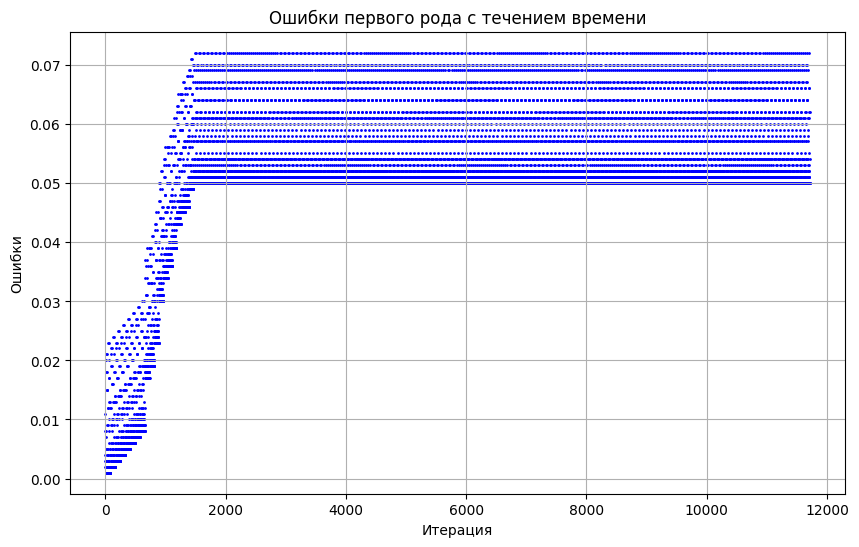

In [114]:
draw_numbers_indexes_scatter(I_errors, title='Ошибки первого рода с течением времени',
                             xlabel='Итерация', ylabel='Ошибки')

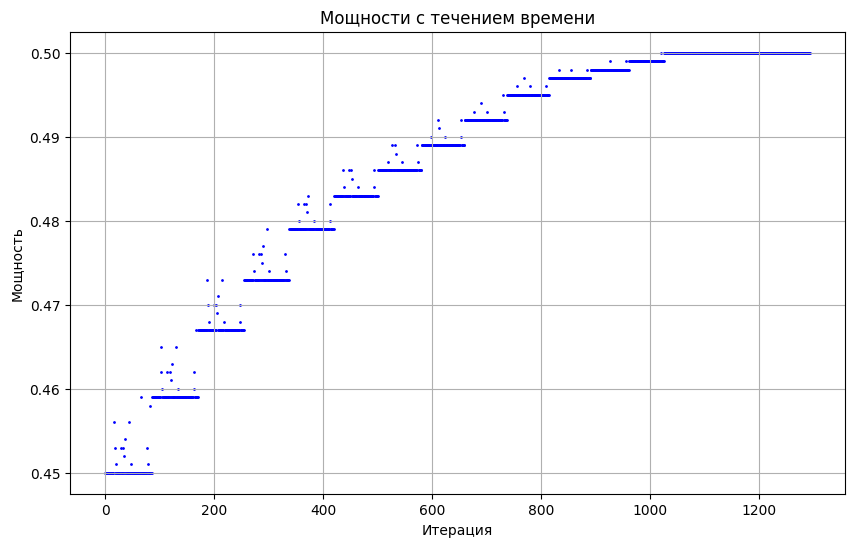

In [115]:
draw_numbers_indexes_scatter(powers, title='Мощности с течением времени',
                             xlabel='Итерация', ylabel='Мощность')

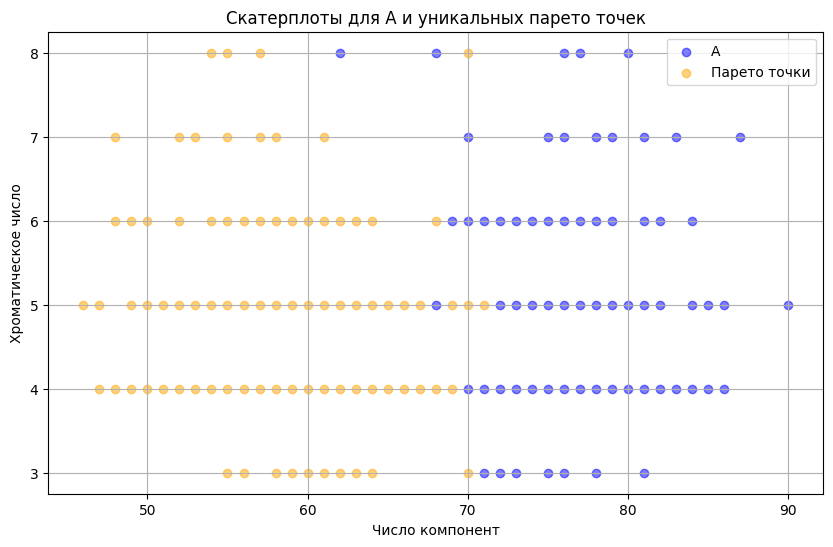

In [116]:
draw_two_points_sets(A, unique_pareto_points, title='Скатерплоты для A и уникальных парето точек',
                     xlabel='Число компонент', ylabel='Хроматическое число',
                     first_legend='A', second_legend='Парето точки')

### 3.2. Класс, находящий $\mathcal{A}$ для данного n

In [ ]:
class DistibutionClassifierSimplified:
    lambda_param = 2 / np.sqrt(3)
    alpha_param = 3
    k = 15
    d = 0.005
    n_param = None
    A_canditates_count = 10
    fitted = False

    exp_points = None
    pareto_points = None

    unique_exp_points = None
    unique_pareto_points = None

    A = None

    def __init__(self, n, A_canditates_count = 10):
        self.n_param = n
        self.A_canditates_count = A_canditates_count

    def generate_chars_points(self):
        print("Generating characteristics...")
        exp_points = []
        pareto_points = []

        for _ in tqdm(range(self.n_param)):
            numbers_exp = np.random.exponential(1/lambda_param, n_param)
            numbers_pareto = (np.random.pareto(alpha_param, n_param) + 1)

            distance_graph_exp = Distance_Graph(n=n_param, d_distance=d)
            distance_graph_pareto = Distance_Graph(n=n_param, d_distance=d)
            distance_graph_exp.build_from_numbers(numbers_exp)
            distance_graph_pareto.build_from_numbers(numbers_pareto)

            chars = create_characteristics(None, distance_graph_exp, None, distance_graph_pareto, "dist")

            exp_points.append((chars.distance_exp_components, chars.distance_pareto_chromatic))
            pareto_points.append((chars.distance_pareto_components, chars.distance_pareto_chromatic))

        exp_points = np.array(exp_points)
        pareto_points = np.array(pareto_points)

        unique_exp_points = np.unique(exp_points, axis=0)
        unique_pareto_points = np.unique(pareto_points, axis=0)

        print("Characteristics generated!")

    def build_A_candidate(self):
        pass # TODO

    def build_A(self):
        print("Building A...")

        A_candidates, powers = [], []
        for _ in tqdm(self.A_canditates_count):
            A_candidate, power = self.build_A_candidate()
            A_candidates.append(A_candidate)
            powers.append(power)

        A_candidates = list(enumerate(A_candidates))
        A = max(A_candidates, key=lambda item : powers[item[1]])[0]

        print("A builded!")

    def fit(self):
        self.generate_chars_points()

        self.build_A()

    def draw_A(self):
        assert self.fitted

    def predict(self, point):
        pass